This tutorial is from ZEISS Arivis - an AI company

Associated Youtube video: https://youtu.be/zpYq1gr1910

## **Multiclass semantic segmentation with U-Net**


* The full dataset can be downloaded from the link below. This dataset can be used to train and test machine learning algorithms designed for multiclass semantic segmentation. Please read the Readme document for more information.
https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view?usp=sharing

* CENG506 students: The part of the dataset used in this notebook consists of images and masks of 128x128 pixels. This subset is in MS-Teams/General/Class Materials/datasets folder with name sandstone-image-segmentation-dataset.zip (22 MB).

In [57]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [94]:
#Resizing images, if needed
SIZE_X = 128
SIZE_Y = 128
n_classes = 4 #Number of classes for segmentation
num_images = 200  #Total 1600 available

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [95]:
#there are 1600 images, we are not going to use all of them
image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/*.tif")
print(image_names)

['/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img498.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img1069.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img615.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img946.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img1380.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img1381.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img958.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img776.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img1598.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img185.tif', '/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/images/img930.tif', '/content/drive/MyDrive/Colab Notebook

In [96]:
#after sorting we will read  num_images  no of images
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 0) for image in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [97]:
mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/sandstone/128_patches/masks/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)


In [98]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (200, 128, 128, 1)
Mask data shape is:  (200, 128, 128)
Max pixel value in image is:  255
Labels in the mask are :  [1 2 3 4]


In [99]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [100]:
#after label encoding
print("Now the labels in the mask are : ", np.unique(mask_dataset_encoded))

Now the labels in the mask are :  [0 1 2 3]


In [101]:
#to match the size of the mask dataset with image dataset
mask_dataset_encoded = np.expand_dims(mask_dataset_encoded, axis = 3)
print(mask_dataset_encoded.shape)

(200, 128, 128, 1)


In [102]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler

In [103]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)

In [104]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [105]:
print(y_train_cat.shape)

(160, 128, 128, 4)


In [106]:
print(y_test_cat.shape)

(40, 128, 128, 4)


In [107]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [108]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [109]:
model = build_unet(input_shape, n_classes=4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_76 (Conv2D)          (None, 128, 128, 64)         640       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_72 (Ba  (None, 128, 128, 64)         256       ['conv2d_76[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_72 (Activation)  (None, 128, 128, 64)         0         ['batch_normalizat

In [138]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 16,
                    verbose=1,
                    epochs=30,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/30
10/10 [==============================] - 8s 776ms/step - loss: 0.0318 - accuracy: 0.9876 - val_loss: 0.0874 - val_accuracy: 0.9722
Epoch 2/30
10/10 [==============================] - 8s 815ms/step - loss: 0.0295 - accuracy: 0.9884 - val_loss: 0.0963 - val_accuracy: 0.9713
Epoch 3/30
10/10 [==============================] - 6s 600ms/step - loss: 0.0293 - accuracy: 0.9885 - val_loss: 0.1102 - val_accuracy: 0.9650
Epoch 4/30
10/10 [==============================] - 7s 772ms/step - loss: 0.0287 - accuracy: 0.9889 - val_loss: 0.1081 - val_accuracy: 0.9685
Epoch 5/30
10/10 [==============================] - 7s 782ms/step - loss: 0.0285 - accuracy: 0.9888 - val_loss: 0.1208 - val_accuracy: 0.9669
Epoch 6/30
10/10 [==============================] - 5s 526ms/step - loss: 0.0308 - accuracy: 0.9876 - val_loss: 0.1799 - val_accuracy: 0.9501
Epoch 7/30
10/10 [==============================] - 5s 496ms/step - loss: 0.0303 - accuracy: 0.9881 - val_loss: 0.0927 - val_accuracy: 0.9718
Epoch 

In [139]:
#Save the model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/sandstone_128x128_200images_120epochs.hdf5')

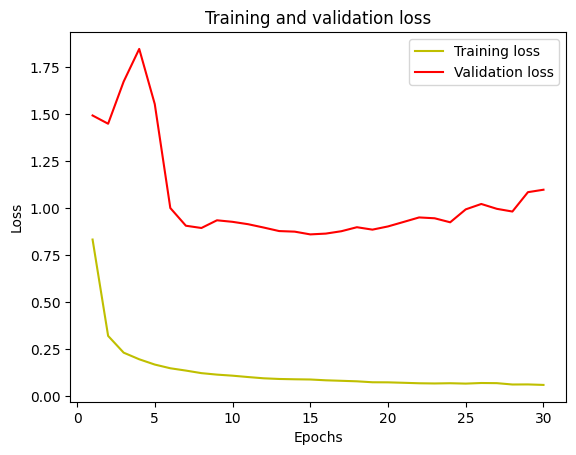

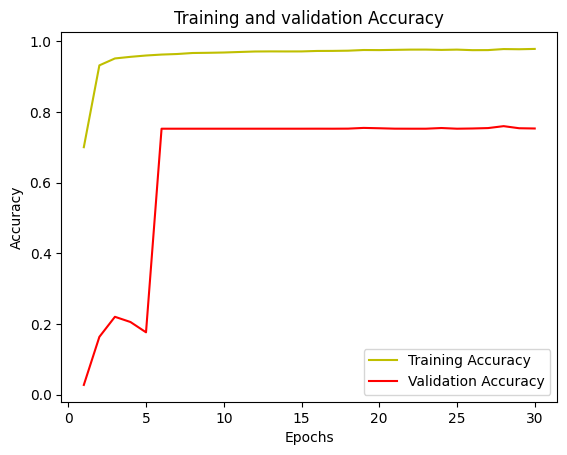

In [111]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [89]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/sandstone_128x128_200images_60epochs.hdf5", compile=False)

In [140]:
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 382ms/step


In [141]:
y_pred.shape

(40, 128, 128, 4)

In [37]:
print(y_pred[0,0:5,0:5,0])

[[0.00214701 0.00040096 0.0006384  0.00064923 0.00050595]
 [0.00209304 0.00050947 0.00034251 0.00030352 0.00051905]
 [0.00062588 0.0001737  0.00011577 0.00046057 0.00031293]
 [0.00109724 0.00022336 0.00036552 0.00050674 0.00107073]
 [0.00111417 0.00036774 0.0004786  0.00130638 0.00368339]]


In [38]:
print(y_pred[0,0:5,0:5,1])

[[0.04859219 0.02823189 0.06587527 0.11950674 0.14538766]
 [0.05360513 0.05624551 0.06373457 0.20715436 0.67449105]
 [0.04484756 0.05132378 0.07817616 0.77902675 0.99050635]
 [0.08257778 0.08831763 0.6968053  0.99286944 0.9984078 ]
 [0.24519438 0.6377829  0.9898782  0.9980805  0.9961138 ]]


In [42]:
print(y_pred[0,0:5,0:5,2])

[[9.4835633e-01 9.7104126e-01 9.3262869e-01 8.7900162e-01 8.5355473e-01]
 [9.4307810e-01 9.4273204e-01 9.3544877e-01 7.9211986e-01 3.2467508e-01]
 [9.5397699e-01 9.4827944e-01 9.2151266e-01 2.2023337e-01 9.1268076e-03]
 [9.1520023e-01 9.1121936e-01 3.0270812e-01 6.5737250e-03 4.9147004e-04]
 [7.5244033e-01 3.6149973e-01 9.5949601e-03 5.7300262e-04 1.2386034e-04]]


In [142]:
# line below selects the highest score class for every pixel and writes it to one matrix (y_pred_argmax)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax.shape

(40, 128, 128)

In [52]:
print(y_pred_argmax[0,0:5,0:5])

[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 1 1]
 [2 2 2 1 1]
 [2 2 1 1 1]]


In [143]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.84681106


With 200 images and 50 epochs MeanIoU is about 0.50, with 90 epochs its about 0.80.

With 1600 images and 50 epochs MeanIoU becomes 0.60.

In [135]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)



[[8.33000e+04 2.36600e+03 1.92850e+04 4.00000e+00]
 [3.34000e+03 2.96010e+04 8.56700e+03 0.00000e+00]
 [1.02900e+03 9.46000e+02 4.91099e+05 8.60000e+01]
 [0.00000e+00 0.00000e+00 8.38000e+02 1.48990e+04]]
IoU for class1 is:  0.76195526
IoU for class2 is:  0.66044176
IoU for class3 is:  0.9410731
IoU for class4 is:  0.941366


1/1 [==============================] - 0s 494ms/step


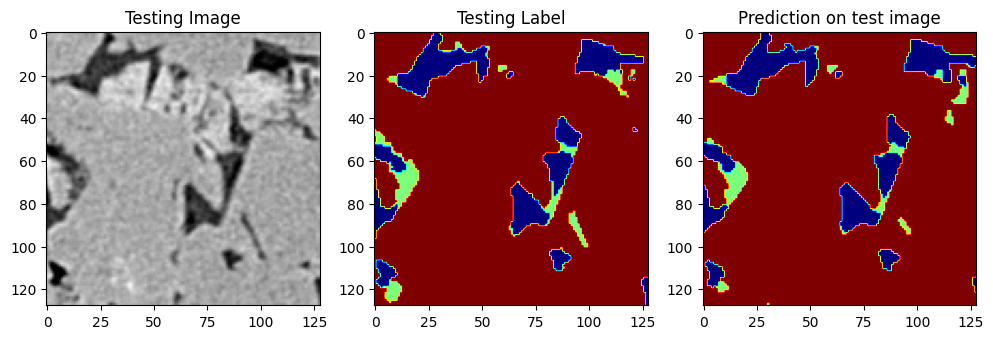

In [137]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()